In [4]:
!pip install transformers huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

In [5]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

In [6]:
import pandas as pd
import numpy as np
from PIL import Image
import io

num_classes = 100
input_shape = (32, 32, 3)

# --- Utility to convert image bytes to array ---
def decode_image(img_bytes, target_size=(32, 32)):
    img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
    img = img.resize(target_size)
    return np.array(img)

# --- Load and process parquet dataset ---
def load_parquet_dataset(train_path, test_path, target_size=(32, 32)):
    # Load train and test parquet
    df_train = pd.read_parquet(train_path)
    df_test  = pd.read_parquet(test_path)


    # Convert images
    x_train = np.stack([decode_image(b["bytes"], target_size) for b in df_train["image"]])
    x_test  = np.stack([decode_image(b["bytes"], target_size) for b in df_test["image"]])



    # Convert labels (string → integer)
    all_labels = pd.concat([df_train["caption"], df_test["caption"]]).unique()
    label2id = {label: idx for idx, label in enumerate(all_labels)}

    y_train = np.array([label2id[label] for label in df_train["caption"]]).reshape(-1, 1)
    y_test  = np.array([label2id[label] for label in df_test["caption"]]).reshape(-1, 1)

    return (x_train, y_train), (x_test, y_test)

# --- Usage ---
(x_train, y_train), (x_test, y_test) = load_parquet_dataset(
    "train-00000-of-00001.parquet",
    "test-00000-of-00001.parquet"
)

print("Train:", x_train.shape, y_train.shape)
print("Test:", x_test.shape, y_test.shape)


Train: (1584, 32, 32, 3) (1584, 1)
Test: (397, 32, 32, 3) (397, 1)


In [7]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100  # For real training, use num_epochs=100. 1 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
@keras.saving.register_keras_serializable()
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


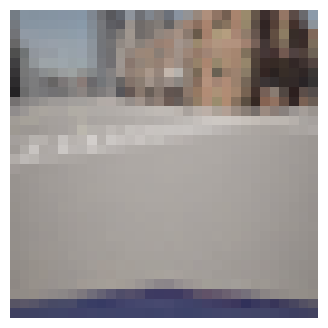

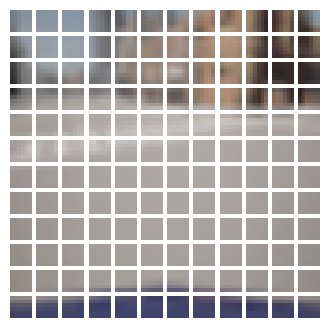

In [11]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [12]:
@keras.saving.register_keras_serializable()
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [13]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [14]:
from huggingface_hub import upload_folder
import tensorflow as tf
import json
import keras
from safetensors import safe_open
from safetensors.numpy import save_file
import numpy as np

In [15]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Save the entire model as a SavedModel.
    !mkdir -p saved_model
    keras.saving.save_model(model, 'saved_model/my_model.keras')

    #Save config file
    with open("saved_model/config.json", "w") as file:
        json.dump(model.get_config(), file)

    # Get a dictionary of the model's weights, mapping layer names to NumPy arrays
    weights = {layer.name: layer.weights[0].numpy() for layer in model.layers if layer.weights}

    # Use the `save_file` function from `safetensors.numpy`
    save_file(weights, "my_keras_model.safetensors")

    print("Keras model weights saved to my_keras_model.safetensors")

    return history

vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 6.3763e-04 - loss: nan - top-5-accuracy: 0.0015 - val_accuracy: 0.0000e+00 - val_loss: nan - val_top-5-accuracy: 0.0000e+00
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 409ms/step - accuracy: 0.0015 - loss: nan - top-5-accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: nan - val_top-5-accuracy: 0.0000e+00
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - accuracy: 3.1211e-04 - loss: nan - top-5-accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: nan - val_top-5-accuracy: 0.0000e+00
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 369ms/step - accuracy: 0.0015 - loss: nan - top-5-accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: nan - val_top-5-accuracy: 0.0000e+00
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step - accuracy: 6.3763e-04 - loss: nan - top-5-accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: nan - val_top-5-accuracy: 0.0000e+00
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accura

In [22]:
from huggingface_hub import HfApi

!huggingface-cli login

api = HfApi()

api.upload_file(
    path_or_fileobj="./my_keras_model.safetensors",                            # Path to the local .safetensors file
    path_in_repo="my_keras_model.safetensors", # Desired path within the Hugging Face repository
    repo_id="Sumukhdev/carla_image_captioning_model",                                 # Target repository on Hugging Face Hub
    repo_type="model",
)

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `hf auth whoami` to get more information or `hf auth logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add t

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ./my_keras_model.safetensors          :  39%|###9      | 33.6MB / 85.4MB            

No files have been modified since last commit. Skipping to prevent empty commit.
